In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))
import Levenshtein
import nltk
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report


['unigram_freq.csv']


In [2]:
# File loading
df  = pd.read_csv('../input/unigram_freq.csv')
print(df.shape)
df.dropna(axis=0,how='any')
print(df.shape)


(333333, 2)
(333333, 2)


In [3]:
lines = [x for x in df['word'] if type(x) == type('a') ]
print("Line Count:",len(lines))
print(lines[:4])

Line Count: 333331
['the', 'of', 'and', 'to']


In [4]:
# Preprocessing
import re
def process(sent):
    sent=sent.lower()
    sent=re.sub(r'[^0-9a-zA-Z ]','',sent)
    sent=sent.replace('\n','')
    return sent    

In [5]:
lines =[process(x) for x in lines]
temp = []
for line in lines:
    temp+= [ x for x in line.split() ]
lines = list(set(temp))
print("\n".join(lines[:4]))
print("Number of items:",len(lines))

mayflower
angele
spinola
uctuations
Number of items: 333331


In [6]:
# CHAR INDEXING
char_set = list(" abcdefghijklmnopqrstuvwxyz0123456789',./?")
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }
print(char2int)
print(int2char)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36, "'": 37, ',': 38, '.': 39, '/': 40, '?': 41}
{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: '0', 28: '1', 29: '2', 30: '3', 31: '4', 32: '5', 33: '6', 34: '7', 35: '8', 36: '9', 37: "'", 38: ',', 39: '.', 40: '/', 41: '?'}


In [7]:
count = len(char_set)
codes = ["\t","\n",'#']
for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1
print(char2int)
print(int2char)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36, "'": 37, ',': 38, '.': 39, '/': 40, '?': 41, '\t': 42, '\n': 43, '#': 44}
{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: '0', 28: '1', 29: '2', 30: '3', 31: '4', 32: '5', 33: '6', 34: '7', 35: '8', 36: '9', 37: "'", 38: ',', 39: '.', 40: '/', 41: '?', 42: '\t', 43: '\n', 44: '#'}


In [8]:
import random
#thresh - 0 to 1
def gen_gibberish(line,thresh=0.2):
    times = int(random.randrange(1,len(line)) * thresh)
    '''
    Types of replacement:
        1.Delete random character.
        2.Add random character.
        3.Replace a character.
        4.Combination?
    '''
    while times!=0:
        # try to gen noise length times...
        times-=1
        val = random.randrange(0,10)
        if val <= 5:
            #get random index
            val = random.randrange(0,10)
            index = random.randrange(2,len(line))
            if val <= 3 :
                #delete character
                line = line[:index]+line[index+1:]
            else:
                #add character
                insert_index = random.randrange(0,len(char_set))
                line = line[:index] + char_set[insert_index] + line[index:]
        else:
            index = random.randrange(0,len(char_set))
            replace_index = random.randrange(2,len(line))
            line = line[:replace_index] + char_set[index] + line[replace_index+1:]
    return line

sample = lines[5]
gib = gen_gibberish(sample)
print("Original:",sample)
print("Gibberish:",gib)
print(len(lines))        
#print(lines)

Original: theresa
Gibberish: thgresa
333331


In [9]:
def alter():
    corrected_text="This is a wrong sentence with errors in spelling and grammatical mistakes. It has incorrect punctuations, missing letters, and wrong word orders. The grammar and spelling are all over the place. The sentences don't make sense, and the words are jumbled up. There are run-on sentences, and many words are misspelled. It's a complete chaos and hard to understand. The wrong sentence is full of typos, and it makes it difficult to read. There's no proper grammar, and the punctuation is all wrong too. It is a mess of words and it's difficult to understand the meaning. The wrong sentence is a great example of how not to write. It's full of errors, and it makes it hard to read. The wrong sentence is a disaster in the land of language. It is a hot mess of words, and it's hard to make any sense of it. The grammar is all over the place, and the spelling is wrong. It is a disaster of a sentence and it is difficult to comprehend. The wrong sentence is a complete garble of letters. It is hard to read, and it is full of mistakes. The word order is all out of place, and the punctuation is incorrect. There's no coherence or structure in the wrong sentence. It's a jumbled mess of incoherent words and it is confusing to read. The wrong sentence is a nightmare for any reader. It is a cacophony of errors, and it is hard to decipher. The wrong sentence is a total disaster, and it is impossible to understand. The grammar is terrible, and the spelling is all over the place. It's a jumble of letters, and it is incomprehensible. The wrong sentence is a train wreck of words, and it is a pain to read. It is full of errors, and it is a complete mess. The wrong sentence is a chaos of typos, and it is difficult to follow."
    corrected_text= corrected_text.lower()
    #print(corrected_text)
    true_labels = nltk.word_tokenize(corrected_text)
    print(true_labels)
    lines=true_labels
    return lines
#lines=alter()    

In [10]:
#print(len(lines))
# create dataset
input_texts = []
target_texts = []
REPEAT_FACTOR = 1
SKIP = int(len(lines)*0.65)

for line in lines[SKIP:]:
    if len(line)>1:
        output_text = '\t' + line + '\n'
        for _ in range(REPEAT_FACTOR):
            input_text = gen_gibberish(line)
            input_texts.append(input_text)
            target_texts.append(output_text)
print("LEN OF SAMPLES:",len(input_texts))

#print(input_texts)
#print(target_texts)

LEN OF SAMPLES: 116662


In [11]:
max_enc_len = max([len(x) for x in input_texts])
max_dec_len = max([len(x) for x in target_texts])
print("Max Enc Len:",max_enc_len)
print("Max Dec Len:",max_dec_len)

Max Enc Len: 36
Max Dec Len: 40


In [12]:
num_samples = len(input_texts)
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)),dtype='float32' )
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+2),dtype='float32' )
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+2),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [13]:
print(char2int)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33, '7': 34, '8': 35, '9': 36, "'": 37, ',': 38, '.': 39, '/': 40, '?': 41, '\t': 42, '\n': 43, '#': 44}


In [14]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    #input_text=input_text.lower()
    for t,char in enumerate(input_text):
        #print(input_text)
        #char = char.lower()
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")    

COMPLETED...


In [15]:
from keras.models import Model
from keras.layers import Input,LSTM,Dense

Using TensorFlow backend.


In [16]:
batch_size = 128
epochs = 200
latent_dim = 256

num_enc_tokens = len(char_set)
num_dec_tokens = len(char_set) + 2 # includes \n \t
encoder_inputs = Input(shape=(None,num_enc_tokens))
encoder = LSTM(latent_dim,return_state=True)
encoder_outputs , state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h,state_c]


In [17]:
decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_ouputs,_,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)

decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)

model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 42)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 44)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 306176      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  308224      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [18]:
h=model.fit([encoder_input_data,decoder_input_data],decoder_target_data
         ,epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2
         )
model.save('s2s.h5')


Train on 93329 samples, validate on 23333 samples
Epoch 1/200
93329/93329 [==============================] - 65s 698us/step - loss: 0.5467 - val_loss: 0.5119
Epoch 2/200
93329/93329 [==============================] - 60s 647us/step - loss: 0.4379 - val_loss: 0.4144
Epoch 3/200
93329/93329 [==============================] - 60s 645us/step - loss: 0.3478 - val_loss: 0.3044
Epoch 4/200
93329/93329 [==============================] - 60s 647us/step - loss: 0.2643 - val_loss: 0.2537
Epoch 5/200
93329/93329 [==============================] - 60s 644us/step - loss: 0.1814 - val_loss: 0.2005
Epoch 6/200
93329/93329 [==============================] - 60s 642us/step - loss: 0.1291 - val_loss: 0.1375
Epoch 7/200
93329/93329 [==============================] - 60s 644us/step - loss: 0.1010 - val_loss: 0.1146
Epoch 8/200
93329/93329 [==============================] - 60s 644us/step - loss: 0.0843 - val_loss: 0.0971
Epoch 9/200
93329/93329 [==============================] - 61s 651us/step - loss: 0.07

/opt/conda/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


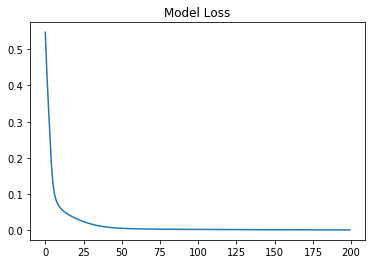

In [19]:
plt.plot(h.history['loss'])
plt.title('Model Loss')
plt.show()

In [20]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(
        decoder_inputs,initial_state = decoder_states_inputs
)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
encoder_model.save('encoder.h5')
decoder_model.save('decoder.h5')

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char2int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int2char[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

sample_text=""
corrected_text=""
result_text=""

for seq_index in range(107):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    wrong_word=input_texts[seq_index]+" "
    corrected_word=decoded_sentence+" "
    ground_word=target_texts[seq_index]+" "
    sample_text+=wrong_word
    corrected_text+=corrected_word
    result_text+=ground_word
    #print('-')
    #rint('Wrong sentence:', input_texts[seq_index])
    #print('Corrected sentence:', decoded_sentence)
    #print('Ground Truth:',target_texts[seq_index])
    
#print(sample_text)
#print(corrected_text)
#print(result_text)

/opt/conda/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'input_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [21]:
def evaluation(sample_text, corrected_text, result_text):
    true_labels = nltk.word_tokenize(corrected_text)
    
    result_predicted = nltk.word_tokenize(result_text)
    wer = Levenshtein.distance(' '.join(true_labels), ' '.join(result_predicted)) / len(true_labels)
    cer = Levenshtein.distance(''.join(true_labels), ''.join(result_predicted)) / len(''.join(true_labels))
    print(f"Word Error Rate (WER): {wer:.2%}")
    print(f"Character Error Rate (CER): {cer:.2%}")

evaluation(sample_text,corrected_text,result_text)

Word Error Rate (WER): 0.93%
Character Error Rate (CER): 0.12%


In [22]:
# trials

In [23]:
# encoder_input_data
# input_seq
# decoded_sentance
# input_texts and target_texts from lines